In [1]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import arviz as az
az.style.use('arviz-darkgrid')

/home/osvaldo/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/osvaldo/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


# Programación probabilística

> Nuestros golems raramente tienen forma física, pero a menudo están hechos de arcilla y viven _in silicio_ como código de computadora -Richard McElreath

La estadística Bayesiana es conceptualmente muy simple, tenemos lo _conocido_ y lo _desconocido_. El teorema de Bayes se utiliza para condicionar lo desconocido usando lo conocido, si tenemos suerte este proceso conducirá a una reducción de la incerteza sobre lo desconocido. Por lo general nos referimos a lo conocido como datos y los consideramos fijo mientras que lo desconocido toma la forma de parámetros de distribuciones de probabilidad. La simpleza conceptual para formular modelos Bayesianos contrasta con la dificultad matemático/computacional para resolverlos. Por muchos años esto fue un verdadero problema y retrasó la adopción de métodos Bayesianos.

A fin de poder resolver los modelos Bayesianos se recurre a métodos numéricos que pueden ser considerados como _motores universales de inferencia_. El hecho que tales motores sean posibles ha motivado el surgimiento de la [programación probabilística](http://probabilistic-programming.org/wiki/Home), este tipo de lenguajes permiten una separación clara entre la creación de los modelos y el proceso de inferencia. 

Un lenguaje de programación probabilístico es en lineas generales un lenguaje que permite al usuario describir un modelo probabilístico completo escribiendo una pocas lineas de código, las necesarias para describir el modelo, y luego proceder a realizar la inferencia de forma automática. Se espera que la programación probabilística tenga un gran impacto en estadística, _machine learning_ y otras disciplinas al permitir que científicos construyan modelos complejos en menor tiempo y de forma menos propensa a errores.

Una buena analogía sobre el impacto que un lenguaje de programación puede tener en la ciencia es la introducción del lenguaje de programación Fortran hace más de 6 décadas. Fortran permitió a los científicos, por primera vez, abstraerse de muchos de los detalles computacionales y centrarse en la construcción de métodos numéricos, modelos y simulaciones de una manera más natural. De manera similar, se espera que los lenguajes de programación probabilísticos escondan del usuario detalles sobre como las probabilidades son manipuladas y como se lleva a cabo la inferencia dejando que los usuarios se centren en la especificación del modelo y en el análisis e interpretación de los resultados.

## Objetivos de este capítulo

*
*
*
*

## Introducción a PyMC3

PyMC3 es un paquete para programación probabilística bajo Python. PyMC3 es lo suficientemente madura para resolver muchos problemas estadísticos.  PyMC3 permite crear modelos probabilísticos usando una sintaxis intuitiva y fácil de leer que es muy similar a la sintaxis usada para describir modelos probabilísticos.

La mayoría de las funciones de PyMC3 están escritas en Python. Mientras que las partes computacionalmente demandantes están escritas en NumPy y [Theano](http://deeplearning.net/software/theano/index.html). Theano Es una librería de Python originalmente desarrollada para _deep learning_ (es la antesesora de TensorFlow, PyTorch, MXNet, etc). Theano permite definir, optimizar y evaluar, de forma eficiente, expresiones matemáticas que involucran arreglos multidimensionales. La principal razón por la cual PyMC3 utiliza Theano es debido a que ciertos métodos de muestreo requieren del cálculo de gradientes de funciones arbitrarias. Theano es capaz de hacer esto utilizando un método llamado diferenciación automática. Además Theano compila código Python a C, haciendo que PyMC3 sea rápido. Esta es toda la información necesaria sobre Theano para poder usar PyMC3.

> Recientemente los desarrolladores de Theano anunciaron que dejarán de desarrollar y mantener esta librería. Por esta razón los desarrolladores de PyMC3 se harán cargo del mantenimiento de Theano, mientras sea necesario para asegurar que PyMC3 siga funcionando adecuadamente. Al mismo tiempo, los desarrolladores de PyMC3 ya están trabajando en un sucesor que no dependa de Theano. Es posible que la nueva versión de PyMC dependa de TensorFlow. Quienes tengan interés pueden leer más detalles sobre esto en este [post](https://medium.com/@pymc_devs/theano-tensorflow-and-the-future-of-pymc-6c9987bb19d5).  

## El problema de la moneda revisitado, usando PyMC3 !

A continuación revisitaremos el problema de la moneda visto en el capítulo anterior, usando esta vez PyMC3 para definir nuestro modelo, hacer inferencia y analizar el _a posterori_! Luego veremos como resolver algunos otros problemas.

A continuación generaremos datos sintéticos, en este caso asumiremos que conocemos el valor the $\theta$ y lo llamaremos `theta_real`, y luego intentaremos _averiguar_ este valor _como si no_ lo conocieramos. En un problema _real_ `theta_real` sería desconocido y realizaríamos un proceso de inferencia precisamtente para averiguar su valor.

In [2]:
np.random.seed(123)
n_experimentos = 4
theta_real = .35  # en una situación real este valor es desconocido
datos = stats.bernoulli.rvs(theta_real, size=n_experimentos)
datos

array([1, 0, 0, 0])

### Creación del modelo

Ahora que tenemos nuestros datos es necesario especificar el modelo. Para ello usaremos una distribución beta (con parámetros $\alpha=\beta=1$) como _a priori_ y la distribución de Bernoulli como likelihood. Usando la notación usual en estadística tenemos:


$$\theta \sim \operatorname{Beta}(\alpha=1, \beta=1)$$
$$y \sim \operatorname{Bin}(n=1, p=\theta)$$


> Cada uno de los elementos del _array_ `datos` es un experimento de Bernoulli, es decir un experimento donde solo es posible obtener dos valores (0 o 1) si en cambio tuviera el número total de "caras" obtenidas en varios experimentos de Bernoulli podríamos modelar el likelihood como una distribución Binomial. 

Esto modelo se traduce casi literalmente a PyMC3, veamos:

In [3]:
with pm.Model() as nuestro_primer_modelo:
    θ = pm.Beta('θ', alpha=1, beta=1)  # a priori
    y = pm.Bernoulli('y', p=θ, observed=datos)  # likelihood
    #y = pm.Binomial('theta',n=n_experimentos, p=theta, observed=sum(datos))

En la primer linea hemos creado un nuevo objeto llamado *nuestro_primer_modelo*. Este objeto contiene información sobre el modelo y las variables que lo conforman. PyMC3 usa el bloque _with_ para indicar que todas las lineas que están dentro de el hacen referencia al mismo modelo (que en este caso se llama *nuestro_primer_modelo*).

La segunda linea de código, especifica el _a priori_, como pueden ver la sintaxis sigue de cerca a la notación matemática, la única diferencia es que el primer argumento es siempre una _cadena_ que especifica el nombre de la variable aleatoria (el nombre es usado internamente por Theano/PyMC3), este nombre siempre deberá coincidir con el nombre de la variable de Python a la que se le asigna. De no ser así el código correrá igual, pero puede conducir a errores y confusiones al analizar el modelo.

 >Es importante recalcar que las variables de PyMC3, como $\theta$ no son números si no objetos que representan distribuciones. Es decir objetos a partir de los cuales es posible calcular probabilidades y generar números aleatorios.

En la tercer linea de código se especifica el _likelihood_, que como verán es similar a la linea anterior con la diferencia que hemos agregado un argumento llamado `observed` al cual le asignamos nuestros datos. Esta es la forma de indicarle a PyMC3 cuales son los datos. Los datos pueden ser números, listas de Python, *arrays* de NumPy o *data_frames* de Pandas.

### Inferencia

Nuestro modelo ya está completamente especificado, lo único que nos resta hacer es obtener el _a posteriori_. Una opción es hacerlo de forma analítica, pero como el título de este capitulo es _programación probabilística_ lo haremos con métodos numéricos ;-)

En PyMC3 la inferencia se realiza escribiendo las siguientes lineas:

In [4]:
with nuestro_primer_modelo:
    trace = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [θ]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:00<00:00, 3591.02draws/s]
/home/osvaldo/anaconda3/lib/python3.6/site-packages/mkl_fft/_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)


Primero llamamos al objeto que definimos como nuestro modelo (*nuestro_primer_modelo*), indicando de esta forma que es sobre ese objeto que queremos realizar la inferencia. En la segunda linea le indicamos a PyMC3 que deseamos 1000 muestras. Esta linea luce inocente, pero internamente PyMC3 está haciendo muchas cosas por nosotros. Algunas de las cuales son detalladas en el mensaje que se imprime en pantalla.

Veamos este mensaje:

* La primer linea indica que PyMC3 ha asignado el método de muetreo NUTS, este es un muy buen método para variables continuas.
* La segunda linea nos da información sobre como se inicializaron los valores de NUTS. Un detalle que por ahora no nos preocupa
* La tercer linea indica que PyMC3 correrá dos cadenas en paralelo, es decir generará dos muestras independientes del _a posteriori_. Esta cantidad puede ser diferente en sus computadoras ya que es determinada automáticamente en función de los procesadores disponibles (que en mi caso son 2). `sample` tiene un argumento `chains` que permite modificar este comportamiento.
* La cuarta linea indica que variable ha sido asignada a cual método de muestreo. En este caso la información es redundante, ya que tenemos una sola variable, pero esto no siempre es así. PyMC3 permite combinar métodos de muestreo, ya sea de forma automática basado en propiedades de las variables a muestrear o especificado por el usuario usando el argumento `step`. 
* La última linea es una barra de progreso con varias métricas sobre la velocidad del muestreo, que en este caso (y para referencia futura) es muy alta. Como se puede ver el número de muestras generadas es de 3000 (aunque pedimos 1000), la razón es que es 1000 por cadena (2 cadenas en mi caso), es decir 2000. Todavía nos queda explciar 1000 muestras _extras_, estas son se corresponden a 500 por cadena y son muestras que PyMC3 utiliza para _auto-tunear_ el método de muestreo. Estás muestras son luego descargadas automáticaemtne ya que no son muestras válidas. La cantidad de pasos que se usan para _tunear_  el algoritmo de muestro se puede cambiar con el argumento _tune_ de la función _sample_.

## Resumiendo el  _a posteriori_

Por lo general, la primer tarea a realizar luego de haber realizado un muestreo es evaluar como lucen los resultados. La función `traceplot` de ArviZ es muy útil para esta tarea.

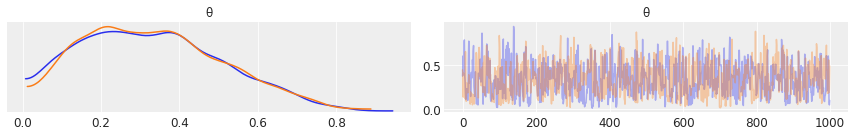

In [5]:
az.traceplot(trace);

Obtenemos dos gráficas, ambas para la variable $\theta$. La gráfica de la izquierda es un KDE-plot (Kernel Density Estimation), es basicamente la versión continua de un histograma. A la derecha tenemos los valores muestreados en función de los pasos (1000 en este caso).

> Es importante notar que la variable y es una variable observada, es decir conocida. El `trace` contiene solo los valore de la variables desconocidas/muestreadas.

Si quisieramos un resúmen numérico de los resultados podemos usar:

In [6]:
az.summary(trace)

/home/osvaldo/anaconda3/lib/python3.6/site-packages/mkl_fft/_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)


,mean,sd,hpd_3,hpd_97,mc_error,n_eff,Rhat
θ,0.34,0.18,0.04,0.67,0.01,821.9,1.0


Como resultado obtenemos un DataFrame con los valores de la media, la desviación estándar y el intervalo HPD 95% (hpd_2.5  hpd_97.5). Estas medidas son propiedades de la variable de interés mientras que las tres últimas son propiedades del muestreo.

* El error introducido por el método de muestreo
* El número efectivo de muestras
* El parámetro de Gelman-Rubin

Another way to visually summarize the posterior is to use the plot_posterior function that comes with ArviZ, we have already used this distribution in the previous chapter for a fake posterior. We are going to use it now will a real posterior. By default, plot_posterior shows a histogram for discrete variables and KDEs for continuous variables. We also get the mean of the distribution (we can ask for the median or mode using the point_estimate argument) and the 95% HPD as a black line at the bottom of the plot. Different interval values can be set for the HPD with the alpha argument. This type of plot was introduced by John K. Kruschke in his great book Doing Bayesian Data Analysis.

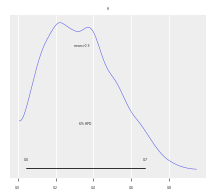

In [7]:
az.posteriorplot(trace);

## Posterior-based decisions

A veces describir el _a posteriori_ no es suficiente,  y es necesario tomar decisiones basadas en nuestras inferencias. Esto suele implicar reducir una estimación continua a una dicotómica: sí-no, enfermo-sano, contaminado-seguro, etc. Es posible, por ejemplo, que tengamos que decidir si la moneda está o no sesgada. Una moneda sesgada sería una que no caiga cara con probabilidad 0.5. Por lo tanto una forma de evaluar el sesgo es comparar el valor de referencia 0.5 contra el intervalo HPD. En la figura anterior, podemos ver que el HPD va de $\approx 0.02$ a $\approx 0.71$ y, por lo tanto, 0.5 está incluido en el HPD. Según el _a posterioriri_ la moneda parece estar sesgada hacia las cecas, pero no podemos descartar por completo el valor de 0.5. Si esta conclusión nos deja sabor a poco entonces tendremos que recopilar más datos para así reducir la varianza del _a posteriori_ o buscar información para definir un _a priori_ más informativo.

#### ROPE

Estrictamente la probabilidad de observar el valor exacto de 0.5 es nula, además en la práctica no nos suele interesar tener precisión infinita si no que solemos tener una idea del rango error que es tolerable o despreciable. Una posibilidad consiste en definir lo que conoce como _región de equivalencia práctica_ o ROPE (_Region Of Practical Equivalence_). Podríamos tener buenas razones para considerar que cualquier valor entre 0,45 y 0,55 es prácticamente equivalente a 0.5. No hay reglas generales para definir un ROPE ya que esta es una decisión contexto-dependient. Para algunos problemas 0.05 podría ser mucho para otros poco, en algunos casos un rango simétrico es útil en otros es una mala idea.

Ya establecido la ROPE podemos usar las siguientes reglas para tomar una decisión:

* El valor de un parámetro es considerado improbable (o rechazado) si la totalidad de la ROPE cae por fuera del HPD 94% del parámetro en cuestión.

* El valor de un parámetro es aceptado si la ROPE contiene por completo al HPD 94% del parámetro en cuestión.

> Una ROPE es un intervalo arbitrario que se determina usando conocimiento previo y relevante sobre un tema. Cualquier valor dentro de este inervalo es considera equivalente.

Usando la función `posteriorplot` de ArviZ, podemos graficar el posterior junto con el HPD y la ROPE.

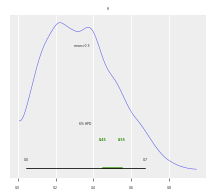

In [8]:
az.posteriorplot(trace, rope=[0.45, .55]); 

Otra herramienta que nos puede asistir en la toma de decisiones es comparar el _a posteriori_ con un valor de referencia. La función `posteriorplot` también nos permite hacer esto:

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f5483fddc88>],
      dtype=object)

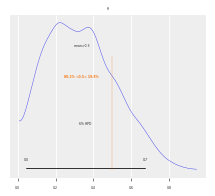

In [9]:
az.posteriorplot(trace, ref_val=0.5) 

El valor de referencia está indicado con una linea naranja, junto con la proporción del posterior por debajo y por arriba del valor de referencia.

Para una discusión más detallada del uso de la ROPE pueden leer el capítulo 12 del gran libro _Doing Bayesian Data Analysis_ de John Kruschke. Este capítulo también discute como realizar pruebas de hipótesis de forma Bayesiana y los problemas de realizar este tipo de análisis ya sea de forma Bayesiana o no-Bayesiana.

Loss functions

If you think these ROPE rules sound a little bit clunky and you want something more formal, loss functions are what you are looking for! To make a good decision is important to have the highest possible level of precision for the estimated value of the relevant parameters, but it is also important to take into account the cost of making a mistake. The cost/benefit trade-off can be mathematically formalized using loss functions, names for loss functions or its inverses vary across different fields, and we could find names such as cost functions, objective functions, fitness functions, utility functions, and so on. No matter the name the key idea is to use a function that captures how different the true value  and the estimated value of a parameter are. The larger the value of the loss function, the worse the estimation is (according to the loss function). Some common examples of loss functions are:

    The quadratic loss (\theta - \hat \theta)^2 
    The absolute loss |\theta - \hat \theta | 
    The 0-1 loss I(\theta \ne \hat{\theta}) I, where is the indicator function.

In practice we generally do not have at hand the value of the true parameter \theta, we instead have an estimation in the form of a posterior distribution. Thus, what we can do is to find out the value of \hat \theta  that minimize the expected loss function. By expected loss function we mean the loss function averaged over the whole posterior distribution. In the following block of code we have two loss functions, the absolute loss ( lossf_a ) and the quadratic loss ( lossf_b ). We explore the value of \hat \theta over a grid of 200 points, we plot those curves and also we include the value of \hat \theta that minimizes each loss function:


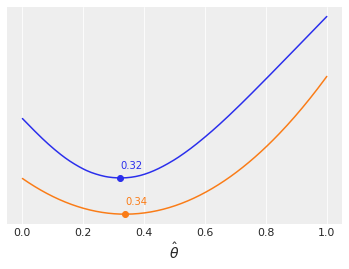

In [10]:
grid = np.linspace(0, 1, 200)
θ_pos = trace['θ']
lossf_a = [np.mean(abs(i - θ_pos)) for i in grid]
lossf_b = [np.mean((i - θ_pos)**2) for i in grid]

for lossf, c in zip([lossf_a, lossf_b], ['C0', 'C1']):
    mini = np.argmin(lossf)
    plt.plot(grid, lossf, c)
    plt.plot(grid[mini], lossf[mini], 'o', color=c)
    plt.annotate('{:.2f}'.format(grid[mini]), (grid[mini], lossf[mini] + 0.03), color=c)
    plt.yticks([])
    plt.xlabel(r'$\hat \theta$')

As we can see result looks somewhat similar for lossf_a \hat \theta = 0.31  and lossf_b \hat \theta = 0.33. What it is interesting from this result is that the first value is equal to the median of the posterior and the last value to the mean of the posterior. You can check this for yourself by computing np.mean(θ_pos), np.median(θ_pos) . I know this is no formal proof but the take home message is:

>Different loss functions are related to different point estimates

OK, so if we want to be formal and we want to compute a single point estimate we must decide which loss function we want, or in reverse if we choose a given point estimate we are implicitly (and maybe even unconsciously ) deciding on a loss function. The advantage of explicitly choosing a loss function is that we can tailor the function to our problem, instead of using some predefined rule that may not be suitable in our particular case. For example, in many problems the cost of making a decision is asymmetric; it is not the same to decide it is safe not to administrate a vaccine to children under five and being right, that being wrong. Making a bad decision could cost thousands of lives and produce a health crisis that could have being avoided by administrating a cheap and safe vaccine. Thus, if our problem demands it we can construct an asymmetric loss function. It also importance to notice as the posterior is in the form of numerical samples we can compute code complex loss functions that not need to be restricted by mathematical convenience or mere simplicity. The following is just a silly example of this:

Text(0.5,0,'$\\hat \\theta$')

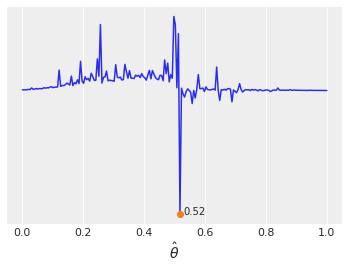

In [11]:
lossf = []
for i in grid:
    if i < 0.5:
        f = np.mean(np.pi * θ_pos / np.abs(i - θ_pos))
    else:
        f = np.mean(1 / (i - θ_pos))
    lossf.append(f)
    
mini = np.argmin(lossf)
plt.plot(grid, lossf)
plt.plot(grid[mini], lossf[mini], 'o')
plt.annotate('{:.2f}'.format(grid[mini]), (grid[mini] + 0.01, lossf[mini] + 0.1))
plt.yticks([])
plt.xlabel(r'$\hat \theta$')

Being said all this, I would like to clarify a point. It is not true that every time people uses a point estimated they are truly thinking in terms of loss functions, in fact loss functions are not very common in many of the scientific fields I am more or less familiar with. People often choose the median, just because is more robust to outlier than the mean, or use the mean just because is a simple and familiar concept, or because they think their observable is truly the an average of some process at some level, like molecules bouncing to each other or genes interacting with themselves and the environment.

We just saw a very brief and superficial introduction to loss functions. If you want to learn more about this you can try reading about decision theory, the field that study formal decision making. .

## Modelos Multiparamétricos

Prácticamente todos los modelos de interés en estadística, son multiparamétricos, es decir modelos con más de un parámetro. 

Suele suceder que no todos los parámetros requeridos para construir un modelo son de interés, supongamos que quisiéramos estimar el valor medio de una distribución Gaussiana, a menos que sepamos el valor _real_ de la desviación estándar, nuestro modelo deberá contener un parámetro para la media y uno para la desviación estándar. Los parámetros que no son de inmediato interés pero son necesarios para definir un modelo de forma completa se llaman _nuisance parameters_ (o parámetro estorbo).

En estadística Bayesiana todos los parámetros tienen el mismo estatus, por lo que la diferencia entre _nuisance_ o no _nuisance_ no es fundamental bajo ningún concepto, si no que depende completamente de nuestras preguntas.

En principio podría parecer que incorporar parámetros que no nos interesan es un ejercicio de futilidad. Sin embargo, es todo lo contrario, al incorporar estos parámetros permitimos que la incertidumbre que tenemos sobre ellos se propague de forma adecuada a los resultados.

En términos generales un modelo con dos parámetros será algo como:

$$P(\theta_1, \theta_2|y) \propto P(y|\theta_1, \theta_2) P(\theta_1, \theta_2)$$

lo que facilmente se puede generalizar a un modelo de más de dos parámetros. La principal diferencia con lo que ya habíamos visto es que ahora el _a posteriori_ será bidimensional (asumiendo que $\theta_1$, $\theta_2$ son unidimensionales).

Supongamos por un momento que $\theta_2$ no nos interesa realmente ¿Como hacemos entonces para expresar el _a posteriori_ solo en términos de $\theta_1$? Lo que debemos hacer es obtener la distribución marginal del _a posteriori_ respecto del parámetro de interés. Matemáticamente esto es:

$$P(\theta_1|y) = \int P(\theta_1, \theta_2|y) d\theta_2$$

Es decir integramos el _a posteriori_ sobre todos los valores posibles de los parámetros que no nos interesan. Para el caso de variables discretas la integral se convierte en una suma.

Al usar PyMC3 no necesitamos marginalizar _manualmente_ los parámetros ya que el _a posteriori_ lo obtenemos como un _array_ que puede ser indexado para obtener la distribución marginal de cualquier parámetro de interés.

###  Inferencias lumínicas

A finales del siglo XIX Simon Newcomb realizó varios experimentos para determinar la velocidad de la luz. En uno de ellos Newcomb midió el tiempo que le tomaba a la luz recorrer 7,4437 kilómetros. 

A continuación se muestra sus resultados, 66 mediciones expresadas en $1\times10^{-2}$ segundos.

In [12]:
datos = np.array([24828, 24826, 24833, 24824, 24834, 24756, 24827, 
                  24816, 24840, 24798, 24829, 24822, 24824, 24821, 
                  24825, 24830, 24823, 24829, 24831, 24819, 24824, 
                  24820, 24836, 24832, 24836, 24828, 24825, 24821, 
                  24828, 24829, 24837, 24825, 24828, 24826, 24830, 
                  24832, 24836, 24826, 24830, 24822, 24836, 24823, 
                  24827, 24827, 24828, 24827, 24831, 24827, 24826, 
                  24833, 24826, 24832, 24832, 24824, 24839, 24828, 
                  24824, 24825, 24832, 24825, 24829, 24827, 24828, 
                  24829, 24816, 24823])



Si graficamos estas medidas veremos que la distribución parece Gaussiana excepto por dos medidas inusualmente bajas.

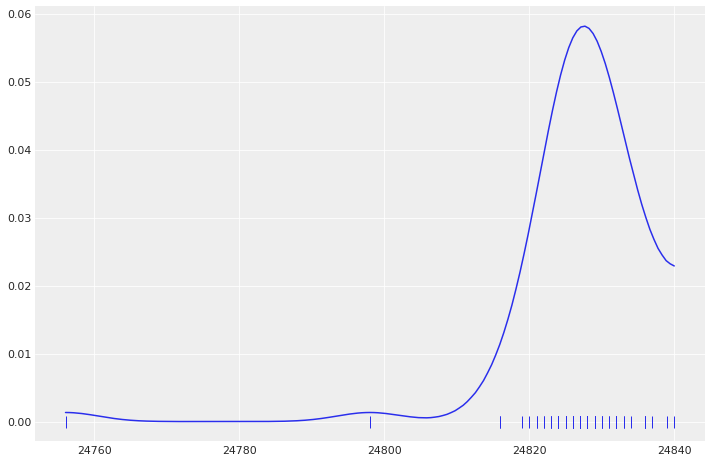

In [13]:
az.kdeplot(datos, rug=True);

Por simplicidad vamos a suponer que los datos siguen una distribución Gaussiana, después de todo es lo que en general se esperaría, en general, al medir una misma _cosa_ varias veces. Una distribución Gaussiana queda definida por dos parámetros, la media y la desviación estándar, como desconocemos estas dos cantidades necesitamos establecer dos _a prioris_ uno para cada parámetro. Un modelo probabilístico razonable sería el siguiente.

$$\mu \sim U(l, h)$$
$$\sigma \sim \text{Half-Normal}(\sigma_{\sigma})$$
$$y \sim \mathcal{N}(\mu, \sigma)$$

Es decir, $\mu$ proviene de una distribución uniforme entre los límites $l$ y $h$ y $\sigma$ proviene de una media-normal (_half-normal_) con desviación estándar $\sigma_{\sigma}$, esta distribución es como una Gaussiana pero restringida al rango $[0, \infty]$. Por último los datos $y$, como dijimos anteriormente, proviene de una distribución normal, especificada por $\mu$ y $\sigma$.


Si desconocemos por completo cuales podrían ser los valores de $\mu$ y de $\sigma$, podemos fijar valores para los _a prioris_ que reflejen nuestra ignorancia. Por ejemplo para $\mu$ forma general de hacer esto es usando los datos por ejemplo podés decir que la media es una distri

Para la distribución uniforme una opción podría ser fijar $(l=0, h=1\times10^9)$, es decir asumimos que el tiempo que le demora a la luz recorrer los 7442 metros del experimento va entre 0 y 1 segundo (el límite inferior de 0 tiene sentido ya que las velocidades no pueden ser negativas, el límite superior de un 1 segundo es un valor elevado en la escala de los datos). Una alternativa podría ser $(l=24000, h=25000)$, que es un rango bastante más amplio que el de los datos.

Otra posibilidad sería usar los datos como guía por ejemplo $(l=datos.min() / 100, h=l=datos.min() * 100)$. De esta forma garantizamos que el _a priori_ contenga el rango de los datos pero que sea mucho más amplio, reflejando que no tenemos demasiado información para fijar un _a priori_ de forma más precisa. 

En la siguiente celda podrán ver que he elegido un par de _a prioris_ y hay otros comentados. Comparen como corre el modelo con los distintos _a prioris_ tanto en términos de los resultados como los tiempos y _calidad_ del muestreo.

In [14]:
with pm.Model() as modelo_g:
    # los a prioris
    μ = pm.Uniform('μ', 24000, 25000)
    #μ = pm.Uniform('μ', 0, 1E9) # un a priori alternativo
    #μ = pm.Normal('μ', 24500, 100) otro a priori alternativo
    σ = pm.HalfNormal('σ', sd=25)
    #σ = pm.HalfNormal('σ', sd=datos.std() * 100)
    # el likelihood
    y = pm.Normal('y', mu=μ, sd=σ, observed=datos)
    trace_g = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ, μ]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:01<00:00, 2552.18draws/s]
/home/osvaldo/anaconda3/lib/python3.6/site-packages/mkl_fft/_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)
The acceptance probability does not match the target. It is 0.8835423011682787, but should be close to 0.8. Try to increase the number of tuning steps.


El traceplot luce bien por lo que podemos continuar con el análisis pero ustedes podrían querer hacer algunas de las pruebas diagnósticas que vimos en el capítulo anterior (solo para estar seguros).

Como se puede ver el traceplot tiene ahora dos filas, una por cada parámetro. Cada una de estas filas corresponde a una variable _marginal_ del _a posteriori_ que en este caso es bi-dimensional.

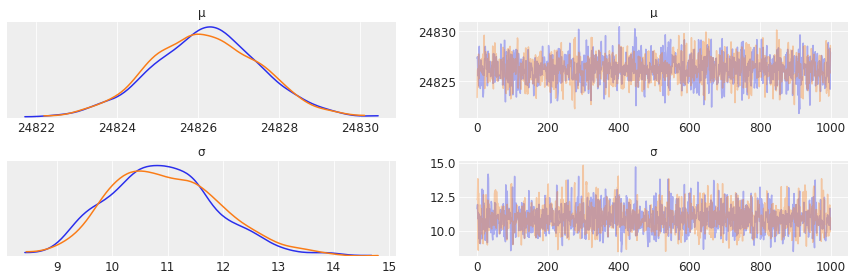

In [15]:
az.traceplot(trace_g);

Vamos a llamar a `summary` y luego usaremos estos valores para compararlos con los de otro modelo.

In [16]:
az.summary(trace_g)

/home/osvaldo/anaconda3/lib/python3.6/site-packages/mkl_fft/_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)


,mean,sd,hpd_3,hpd_97,mc_error,n_eff,Rhat
μ,24826.17,1.33,24823.58,24828.57,0.03,2173.34,1.0
σ,10.92,0.99,9.24,12.81,0.02,2000.23,1.0


A continuación podemos observar la distribución _a posteriori_ (que como ya mencionamos en bidimensional)

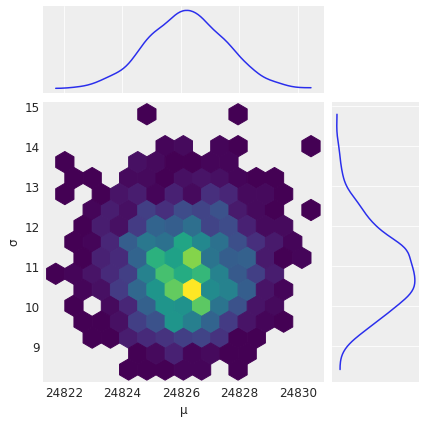

In [17]:
az.jointplot(trace_g, kind='hexbin');

Una vez computado el _a posteriori_ podemos realizar diversos cálculos a partir de el. Uno de esos cálculos consiste en _simular datos_ ($\tilde{y}$). Matemáticamente lo que queremos calcular es:

$$p(\boldsymbol{\tilde{y}} \,|\, \boldsymbol{y}) = \int p(\boldsymbol{\tilde{y}} \,|\, \theta) \, p(\theta \,|\, \boldsymbol{y}) \, d\theta$$

donde:

$\boldsymbol{y}$ son los datos observados mientras que $\theta$ corresponde a los parámetros del modelo. 

Siguiendo el ejemplo de la velocidad de la luz $\theta$ corresponde a $\mu$ y a $\sigma$ y computacionalmente podemos obtener $\boldsymbol{\tilde{y}}$ de la siguiente forma:

1. Elegimos al azar un índice del `trace` generado por PyMC3 (un valor para $\mu_i$ y $\sigma_i$)
2. Generamos un _dato sintético_ $\tilde{y_i}  \sim N(\mu_i, \sigma_i)$
3. Repetimos 1 y 2 cuantas veces necesitemos.

Usando PyMC3 es muy fácil generar datos a partir del _a posteriori_. El siguiente código devuelve 100 predicciones cada una de ellas de tamaño igual al de los datos (esto es importante para que la comparación sea _justa_).

In [18]:
ppc = pm.sample_ppc(trace_g, 100, modelo_g)

100%|██████████| 100/100 [00:00<00:00, 1539.68it/s]


Los datos simulados los podemos usar para compararlos con los datos observados y de esta forma evaluar el modelo. Esto se conoce como prueba predictivas _a posteriori_ y ya adelantamos algo en el capítulo 1. En la siguiente gráfica la linea azul corresponde a los datos observados mientras que las lineas magentas (semitrasparentes) corresponden a datos predichos por el modelo.

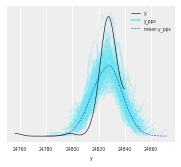

In [23]:
az.ppcplot(datos, ppc);

Según la gráfica anterior, ¿Cuán bueno considerás que es nuestro modelo?

###  Modelos robustos

Un problema con el modelo anterior es que asume una distribución normal pero tenemos dos puntos que caen muy alejados de los valores medios. Esos puntos podrían estar alejados debido a errores experimentales en la toma de esos dos datos o podría haber un error al registrar los o al trascribirlos. Si algo de esto sucedió podríamos justificar su eliminación de nuestro conjunto de datos (dejando registro de la eliminación y de las razones por las cuales lo hicimos). Otra opción es usar el rango inter-cuartil (u otro método _estadístico_) para declarar esos dos puntos como datos aberrantes y desterrarlos de nuestros datos! Otra opción es dejarlos pero utilizar un modelo más robusto a valores alejados de la media. 

Uno de los inconvenientes al asumir normalidad, es que la media es muy sensible a valores aberrantes. La razón está en la colas de la Gaussiana, aún cuando las colas se extienden de $-\infty$ a $\infty$, la probabilidad de encontrar un valor cae rápidamente a medida que nos alejamos de la media, como se puede apreciar en la siguiente tabla que indica el porcentaje de valores que se encuentra a medida que nos alejamos de la media en unidades de desviación estándar (sd).

| sd |  % |
|:-:|:-:|
| 1 |  68 |
| 2 | 95  |
| 3 | 99.7 |
| 4 | 99.994 |
| 5 | 99.99994 |

Una alternativa a la distribución Gaussiana es usar una distribución t de Student, lo interesante de esta distribución es que además de estar definida por una media y una escala (análogo de la desviación estándar) está definida por un parámetro usualmente llamado $\nu$. Por su uso en estadística frecuentista $\nu$ se llama grados de libertad pero para el uso que se le suele dar en estadística Bayesiana tiene más sentido seguir la recomendación de Kruschke y llamarle parámetro de _normalidad_, ya que $\nu$ controla cuan _gordas_ son las colas de la distribución. Cuando $\nu = 1$ (la distribución se llama de Cauchy o de Lorentz) las colas son muy gordas, el 95% de los puntos está entre -12,7 y 12,7, en cambio en una Gaussiana (con desviación estándar 1) esto ocurre entre -1,96 y 1,96. En el límite de $\nu$ tendiendo a infinito estamos en presencia de una Gaussiana. La distribución t es realmente particular, cuando $\nu <= 1$ la distribución no tiene media definida y la varianza solo está definida para valores de $\nu > 2$.

La siguiente figura muestra una distribución t de Student para distintos valores de $\nu$.

In [ ]:
plt.figure(figsize=(8, 6))

x_values = np.linspace(-10, 10, 200)
for df in [1, 2, 5, 30]:
    distri = stats.t(df)
    x_pdf = distri.pdf(x_values)
    plt.plot(x_values, x_pdf, label=r'$\nu$ = {}'.format(df))

x_pdf = stats.norm.pdf(x_values)
plt.plot(x_values, x_pdf, label=r'$\nu = \infty$')
plt.xlabel('$x$', fontsize=16)
plt.ylabel('$pdf(x)$', rotation=90, fontsize=16)
plt.legend(loc=0, fontsize=14)
plt.xlim(-7, 7);

Ahora que conocemos la distribución t de Student, podemos usarla en nuestro modelo:

$$\mu \sim U(l, h)$$
$$\sigma \sim \mathcal{HN}(\sigma_h)$$
$$\nu \sim Expon(\lambda)$$
$$y \sim \mathcal{t}(\mu, \sigma, \nu)$$

En algunos modelos puede ser buena idea sumar 1 a la distribución exponencial a fin de asegurarse que $\nu \ge 1$ . En principio $\nu$ puede tomar valores de [0, $\infty]$, pero en mi experiencia valores de $\nu < 1$ pueden traer problemas durante el muestreo, ya que pueden aparecer valores demasiado alejados de la media (las colas son extremadamente gordas!). Esto puede ocurrir con modelos con datos _marcadamente aberrantes_, veremos un ejemplo de esto en el capítulo 4.

Gráficamente:

<img src="imagenes/velocidad_luz_t.png" width=400>

In [ ]:
with pm.Model() as modelo_t:
    # los a prioris
    μ = pm.Uniform('μ', 24000, 25000)
    σ = pm.HalfNormal('σ', sd=10)
    ν = pm.Exponential('ν', 1/30)
    # el likelihood
    y = pm.StudentT('y', mu=μ, sd=σ, nu=ν, observed=datos)
    trace_t = pm.sample(2000)

In [ ]:
pm.traceplot(trace_t);

In [ ]:
pm.summary(trace_t).round(2)

En este caso, vemos que la estimación de $\mu$ es muy similar entre los dos modelos, aunque la estimación de $\sigma$, pasó de ser de ~10 a ~4. Esto es consecuencia de que la distribución t asigna menos peso a los valores alejados de la media que la distribución Gaussiana.

Nota: Según mediciones más modernas $\mu$ debería andar alrededor de ~22315, bastante alejado de las medidas realizadas por Newcomb en este experimento (otros experimentos realizados por el dieron valores más cercanos a las medidas actuales).

In [ ]:
#sns.kdeplot(trace_t['mu'], trace_t['sigma']);

Hagamos un prueba predictiva _a posteriori_ para el nuevo modelo.

In [ ]:
ppc = pm.sample_ppc(trace_t, 100, modelo_t, size=len(datos))

In [ ]:
for ỹ in ppc['y']:
    sns.kdeplot(ỹ, color='C1', alpha=0.1)
sns.kdeplot(datos)
plt.xlim(24700, 25000)

¿Qué conclusión se puede sacar de comparar esta ppc con la anterior?

### Accidentes mineros

Este ejemplo está tomado del [tutorial](http://pymc-devs.github.io/pymc3/getting_started/#case-study-2-coal-mining-disasters) de PyMC3. 

El problema es el siguiente tenemos un registro del número de accidentes en minas de carbón ubicadas en el Reino Unido que ocurrieron entre 1851 y 1962 ([Jarrett, 1979](http://biomet.oxfordjournals.org/content/66/1/191.abstract)). Se sospecha que la aplicación de ciertas regulaciones de seguridad tuvo como efecto una disminución en la cantidad de catástrofes. Por lo tanto nos interesa averiguar el año en que la tasa cambió y nos interesa estimar ambas tasas. 

Los datos son los siguientes, por un lado tenemos la variable _catástrofes_ que contiene la cantidad de accidentes por año y por el otro la variable _años_ conteniendo el rango de años para los cuales tenemos datos. Si prestan atención verán que _catástrofes_ es un arreglo enmascarado (o _masked array_). Esto es un tipo especial de arreglo de NumPy donde cada elemento del arreglo contiene asociado un valor _True_ o _False_ el cual indica si el elemento debe o no ser usado durante cualquier tipo de operación. En este caso como faltan datos para dos años lo que se ha hecho es marcar esa falta de datos con un valor centinela de -999, esta es la forma de indicarle a PyMC3 la presencia de datos faltantes, alternativamente se pueden pasar los datos como un _dataframe_ de Pandas conteniendo el valor especial `NAN` (que es el valor por defecto en Pandas para lidiar con datos faltantes).

Bien, pero para que molestarse con datos faltantes si en general es más fácil eliminarlos. una de las razones es que esto puede conducir a pérdida de información cuando por cada observación tenemos más de una variable o cantidad de interés. Por ejemplo si tenemos 50 sujetos a los que les hemos medido la presión, la temperatura y el ritmo cardíaco, pero sucede que para 4 de ellos no contamos con el datos de la presión (por que alguien se olvidó de medirlo o registrarlo, o por que el tensiómetro se rompió, o por lo que sea). Podemos eliminar esos cuatro sujetos del análisis y perder por lo tanto información sobre la presión y ritmo cardíaco, o podemos usar todos los datos disponibles y además estimar los valores de temperatura faltantes. En el contexto de la estadística Bayesiana los datos faltantes se tratan como un parámetro desconocido del modelo que puede ser estimado.

In [ ]:
datos = np.ma.masked_values([4, 5, 4, 0, 1, 4, 3, 4, 0, 6, 3, 3, 4, 0, 2, 6,
                             3, 3, 5, 4, 5, 3, 1, 4, 4, 1, 5, 5, 3, 4, 2, 5,
                             2, 2, 3, 4, 2, 1, 3, -999, 2, 1, 1, 1, 1, 3, 0, 0,
                             1, 0, 1, 1, 0, 0, 3, 1, 0, 3, 2, 2, 0, 1, 1, 1,
                             0, 1, 0, 1, 0, 0, 0, 2, 1, 0, 0, 0, 1, 1, 0, 2,
                             3, 3, 1, -999, 2, 1, 1, 1, 1, 2, 4, 2, 0, 0, 1, 4,
                             0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1], value=-999)
años = np.arange(1851, 1962)

In [ ]:
plt.plot(años, datos, '.')
plt.ylabel("Número de accidentes")
plt.xlabel("Año");

Para modelar los accidentes usaremos una distribución de Poisson. Como creemos que la cantidad media de accidentes es distinta antes y después de la introducción de regulaciones de seguridad usaremos dos valores de tasas medias de accidentes ($t_0$ y $t_1$). Además deberemos estimar un punto de corte ($pc$) que dividirá los años para los cuales se aplica la tasa de accidentes $t_0$ de los cuales se aplica la tasa $t_1$:

$$A_t \sim Poisson(tasa)$$

$$tasa = \begin{cases}
t_0, \text{si } t \ge pc,\\
t_1, \text{si } t \lt pc
\end{cases}$$

Los _a prioris_ que usaremos serán:

$$t_0 \sim Expon(1)$$
$$t_1 \sim Expon(1)$$
$$pc \sim U(A_0, A_1)$$

Donde la distribucion uniforme es discreta y $A_0$ y $A_1$ corresponden al primer y último año considerado en el análisis respectivamente 


Gráficamente el modelo es:



Una peculiaridad de la implementación de este modelo en PyMC3 es el uso de la función `pm.switch` (linea 10). Esta es en realidad una función de Theano y equivale a un _if else_ de Python. Si el primer argumento es _True_ entonces devuelve el segundo argumento caso contrario el tercer argumento. Como resultado tenemos que _tasa_ es un vector de longitud igual a la de _años_ y cuyos elementos corresponden a una repetición $t_0$ seguida de una repetición $t_1$, la cantidad exacta de repeticiones de $t_0$ y $t_1$ está controlada por la condición $pc \ge$ _años_. De esta podemos al muestrear $pc$ modificamos que años reciben cual tasa para el cálculo del _likelihood_.

In [ ]:
# tasa = []
# for año in años:
#     if pc >= años:
#         tasa.append(t_0)
#     else:
#         tasa.append(t_1)

In [ ]:
with pm.Model() as modelo_cat:

    pc = pm.DiscreteUniform('pc', lower=años.min(), upper=años.max(), testval=1900)

    # Priors para las tasas antes y después del cambio.
    t_0 = pm.Exponential('t_0', 1)
    t_1 = pm.Exponential('t_1', 1)

    # Asignamos las tasas a los años de acuerdo a pc
    tasa = pm.math.switch(pc >= años, t_0, t_1)

    disasters = pm.Poisson('disasters', tasa, observed=datos)
    trace_cat = pm.sample(4500)

In [ ]:
pm.traceplot(trace_cat);

In [ ]:
pm.summary(trace_cat).round(2)

In [ ]:
plt.figure(figsize=(10, 8))
plt.plot(años, datos, '.')
plt.ylabel("Número de accidentes", fontsize=16)
plt.xlabel("Año", fontsize=16)

plt.vlines(trace_cat['pc'].mean(), datos.min(), datos.max(), color='C1', lw=2)
accidentes_promedio = np.zeros_like(datos, dtype='float')
for i, año in enumerate(años):
    idx = año < trace_cat['pc']
    accidentes_promedio[i] = ((trace_cat['t_0'][idx].sum() + trace_cat['t_1'][~idx].sum()) 
                              / (len(trace_cat) * trace_cat.nchains))

pc_hpd = pm.hpd(trace_cat['pc'])
plt.fill_betweenx([datos.min(), datos.max()], pc_hpd[0], pc_hpd[1], alpha=0.3, color='C1');
plt.plot(años, accidentes_promedio,  'k--', lw=2);

# 2. Comparando más de 2 grupos

One pretty common statistical analysis is group comparison. For example, we may be interested in how well patients respond to some drug, the reduction of car accidents by the introduction of a new traffic regulation, student performance under different teaching approaches, and so on. Sometimes this type of question is framed under the hypothesis-testing scenario with the goal of declaring a result statistically significant. Relying only on statistical significance can be problematic for many reasons: on the one hand, statistical-significance is not equivalent to practical-significance; on the other hand, a really small effect can be declared significant just by collecting enough data. 

The idea of statistical significance is connected to the concept of p-values. There is a long record of studies and essays showing that, more often than not, p-values are used and interpreted the wrong way, even by persons using them on a daily basis. Instead of doing hypothesis testing we are going to take a different route and we are going to focus on estimating the effect size, that is quantifying the difference between two groups. One advantage of thinking in terms of effect size is that we move away the yes-no questions like  Does it work?, Is there any effect? to the more nuance type of question like  How well does it work? How large/small the effect is?
The Effect size is just a way to quantify the size of the difference between two groups.

Sometimes when comparing groups, people talk about a control group and a treatment group (or maybe more than one control and treatment groups). This makes sense, for example, when we want to test a new drug: because of the placebo effect and other reasons we want to compare the new drug (the treatment) against a control group (a group not receiving the drug). In this case, we want to know how well one drug works compared to doing nothing (or, as is generally done, against the placebo effect). One alternative interesting question will be how good a new drug is compared with the (already approved) most-popular drug to treat that illness. In such a case, the control group cannot be a placebo; it should be the other drug. Bogus control groups are a splendid  way to lie using statistics. For example, imagine you work for a dairy-product company that wants to sell overly sugared yogurts to kids by telling their dads and moms this particular yogurt boosts the immune system or help their kids grow stronger. One way to cheat and falsely back up your claims with data is by using milk or even water as a control group, instead of another cheaper, less sugary, less marketed yogurt. It may sound silly put this way but there is a lot of research done this way. When someone says something is harder, better, faster, stronger, remember to ask what is the baseline used for the comparison.

To compare groups we must decide which feature (or features) are we going to use for the comparison.  A very common feature is the mean of each group.  Because we are Bayesian we will work to obtain a posterior distribution of the differences of means between groups and not just a point estimate of the differences. To help us see and interpret such posterior we are going to use 3 tools.

    A posteriorplot with a reference value.
    The Cohen's d 
    The probability of superiority

In the previous chapter we have already seen an example of how to use posteriorplot with a reference value, we will see another example soon. The novelties here are the Cohen's d and the probability of superiority, two popular ways to express the effect size.

Cohen's d

A common way to measure the effect size is the Cohen's d:

According to this expression  the effect size is the difference of the means with respect to the pooled standard deviation of both groups. Because we can get a posterior distribution of means and standard deviations we can compute a posterior distribution of Cohen's d values. Of course if we just need or want one single value, we can compute the mean of that posterior distribution and get a single Cohen's d value. Generally when computing a pooled standard deviation we take into account the sample size of each group explicitly, but the previous formula is omitting the sample size of both groups, the reason for this is that we are getting the values of the standard deviation from the posterior and thus we are already accounting for the standard deviations' uncertainty.

Cohen's d is a way to measure the effect size where the difference of the means are standardized by considering the pooled standard deviations of both groups.

Cohen's d introduces the variability of each group by using their standard deviations. This is really important, a differences of 1 when you have a standard deviation of 0.1 seems large compared to the same difference when the standard deviation is 10.  Also a change of x units from one group to another could be explained by every individual data point changing exactly x units or by half of them not changing and the other half changing 2x units, and by many other combinations. Thus including the intrinsic variations of groups is a way to put the differences in context.  Re-scaling (standadizing) the differences helps us to make sense of the importance of the different between groups even when we are not very familiar with the scale used for the measurements. 
A Cohen's d can be interpreted as a Z-score (aka standard-score). A Z-score is the signed number of standard deviations by which a value differs from the mean value of what is being observed or measured. Thus a Cohen's d of 0.5 could be interpreted as a difference of 0.5 standard deviation of one group with respect to the other. 

Even when the differences of means are standardized we may still need to calibrate ourselves based on the context of a given problem to be able to say if a given value is big, small, medium, and so on. Fortunately, this calibration can be acquired with enough practice, just as an example if we are used to perform several analyses for more or less the same type of problems, we can get used to a Cohen's d of say 1, so when we get a Cohen's d of say 2 we know we have something important (or someone made a mistake somewhere!). If you do not have this practice yet you can ask a domain-expert for her valuable input. A very nice web page to explore how different values of Cohen's d look like is http://rpsychologist.com/d3/cohend. On that page, you will also find other ways to express an effect size; some of them could be more intuitive, such as the probability of superiority that we will discuss next.
Probability of superiority

This is another way to report the effect size and is defined as the probability that a data point taken at random from one group has a larger value than one also taken at random from the other group. If we assume the data we are using is distributed as a normal, we can compute the probability of superiority from the Cohen's d  using the expression:

Here,  is the cumulative normal distribution and  is the Cohen's d. We can compute a point estimation of the probability of superiority (what is usually reported) or we can compute the whole posterior distribution of values. If we are ok with the normality assumption we can use this formula to get the probability of superiority from the Cohen's d. Otherwise as we have samples from the posterior we can directly compute it (see the exercise section). This is a very nice advantage of using MCMC methods, once we get samples from the posterior we can compute many quantities from it.

The tips dataset

To explore the subject matter of this section, we are going to use the tips dataset. This data was reported for the first time by Bryant, P. G. and Smith, M (1995) Practical Data Analysis: Case Studies in Business Statistics.

We want to study the effect of the day of the week on the amount of tips at a restaurant. For this example, the different groups are the days, notice there is no control group or treatment group.  If we wish, we can arbitrarily establish one day, for example, Thursday, as the reference or control. For now, let's start the analysis by loading the dataset as a Pandas dataframe using just one line of code. If you are not familiar with Pandas, the tail command is used to show the last rows of a dataframe (you can also try using head):

In [ ]:
tips = pd.read_csv('tips.csv')
tips.tail()

From this data frame, we are only going to use the day and tip columns. We can plot our data using the violinplot function from seaborn:

In [ ]:
sns.violinplot(x='day', y='tip', data=tips);

Just to simplify things, we are going to create three variables: the variable y representing the tips the variable idx a categorical dummy variable to encode the days with numbers, that is, [0, 1, 2, 3] instead of [Thursday, Friday, Saturday, Sunday]. Lastly the variable groups with the number of groups (4): 

In [ ]:
y = tips['tip'].values 
idx = pd.Categorical(tips['day']).labels 
groups = len(np.unique(idx)

The model for this problem is almost the same as model_g; the only difference is that now  and are going to be vectors instead of scalar variables. In other words, every time we sample from our priors, we are going to get four values for  and four values for , instead of one as in our previous model. PyMC3 syntax is extremely helpful for this situation: instead of writing for loops, we can write our model in a vectorized way. This means that for the priors we pass a shape argument and for the likelihood, we properly index the variables means  and sds using the idx variable:

In [ ]:
with pm.Model() as comparing_groups:         
    μ = pm.Normal('μ', mu=0, sd=10, shape=groups) 
    σ = pm.HalfNormal('σ', sd=10, shape=groups) 
 
    y = pm.Normal('y', mu=μ[idx], sd=σ[idx], observed=y) 
     
    trace_cg = pm.sample(5000) 
az.traceplot(trace_cg)

In [ ]:
az.summary(cadena_best_ext, varnames)

Una vez obtenidos el _a posteriori_ podemos hacer todos los análisis que creamos pertinentes, por ejemplo calcular todas las diferencias de medias _a posteriori_ entre si, junto con los valores correspondientes de la _probabilidad de superioridad_ y _d de Cohen_.

The following code is just a way to plot the difference without repeating the comparison. Instead of plotting the all-against-all matrix, we are just plotting the upper triangular portion:

In [ ]:
dist = stats.norm()

_, ax = plt.subplots(3, 2, figsize=(16, 12))

comparisons = [(i,j) for i in range(4) for j in range(i+1, 4)]
pos = [(k,l) for k in range(3) for l in (0, 1)]

for (i, j), (k,l) in zip(comparisons, pos):
    means_diff = trace_cg['μ'][:,i] - trace_cg['μ'][:,j]
    d_cohen = (means_diff / np.sqrt((trace_cg['σ'][:,i]**2 + trace_cg['σ'][:,j]**2) / 2)).mean()
    ps = dist.cdf(d_cohen/(2**0.5))
        
    az.posteriorplot(pd.DataFrame(means_diff, columns=['$\mu_{}-\mu_{}$'.format(i, j)]),
                     ref_val=0, ax=ax[k, l])
    ax[k, l].plot(0, label="Cohen's d = {:.2f}\nProb sup = {:.2f}".format(d_cohen, ps), alpha=0)
    ax[k,l ].legend(fontsize=14)
plt.tight_layout()

One way to interpret these results is by comparing the reference value with the HPD interval. According to the previous figure, we have only one case when the 95% HPD excludes the reference value of zero, the difference in tips between Thursday and Sunday. For all the other examples, we cannot rule out a difference of zero (according to the HPD-reference-value-overlap criteria). But even for that case, is an average difference of ≈0.5 dollars large enough? Is that difference enough to accept working on Sunday and missing the opportunity to spend time with family or friends? Is that difference enough to justify averaging the tips over the four days and giving every waitress and waiter the same amount of tip-money? Those kinds of questions cannot be answered by statistics, they can only be informed by statistics.

## Modelos Jerárquicos

El siguiente ejemplo está tomado del capítulo 9 del libro "Doing Bayesian Data Analysis de John K. Kruschke". Supongamos que en vez de 1 moneda tenemos 3, supongamos además que sabemos que las tres monedas fueron echas con la misma matriz (en la misma fábrica). Para estimar el valor de $\theta$ tenemos dos opciones:

1) estimar un valor de $\theta$ para cada moneda por separado.

2) juntar las tres monedas en un mismo conjunto de datos y calcular un solo valor de $\theta$

La ventaja de la opción 1 es que las monedas podrían diferir entre si por lo que calcular 3 valores de  $\theta$ podría ser muy informativo. La desventaja de este modelo es que hace caso omiso a la información que indica que las 3 monedas tienen un origen común, por lo que es probable que compartan características.

La ventaja de la opción 2 es que la cantidad de datos por parámetro aumentó, lo que reduce la incerteza. El problema es que pasamos a asumir que las 3 monedas son en realidad una, lo cual no sería problemático si las tres monedas fueran muy similares entre si, pero esto podría no ser una buena aproximación.

Una tercera opción es hacer algo a mitad de camino entre 1 y 2. Esto se consigue construyendo un modelo jerárquico o modelo multinivel. Este tipo de modelo nos permitirá estimar un valor de $\theta$ para cada moneda de forma tal que la estimación de cada valor de $\theta$ influencie al resto.

En estadística Bayesiana construir modelos jerárquicos es sencillo. A continuación veremos que un modelo jerárquico para las 3 monedas es muy similar al usado para el caso de 1 sola moneda solo que ahora colocamos un _a priori_ sobre el _a priori_!

Recordemos, el modelo del capítulo anterior era:

$$\theta \sim \operatorname{Beta}(\alpha, \beta)$$
$$y \sim \operatorname{Bin}(n=1, p=\theta)$$

En un modelo jerárquico los argumentos de la distribución Beta ($\alpha$ y $\beta$) no son constantes si no que son valores que proviene de alguna otra distribución. En nuestro tendremos que:

$$ \mu \sim \operatorname{Beta}(\alpha, \beta)$$
$$ \kappa = \operatorname{Gamma}(s, r)$$

$$\theta \sim \operatorname{Beta}(\alpha=\mu  \kappa, \beta=(1 - \mu)  \kappa)$$
$$y \sim \operatorname{Bin}(n=1, p=\theta)$$

Gráficamente, tenemos:

<img src="imagenes/modelo_3_monedas_jerarquico.png" width=250>

En los modelos jerárquicos a $\mu$ y a $\kappa$ se llama _hiper a prioris_ o _hiperparámetros_ ya que son ellos quienes determinan el valor del _a priori_. La diferencia entre el modelo del capítulo anterior y el del presente es que ahora los valores que puede tomar $\theta$ dependen no ya de una distribución fija($\alpha=1$ y $\beta=1$) si no de una distribución que depende de los valores de $\mu$ y $\kappa$, y que estimaremos a partir de los datos. Es decir es posible estimar el _a priori_ a partir de los datos, pero solo por que hemos introducido _hiper a prioris_. 

Recordarán que la distribución Beta se podía parametrizar en términos de $\alpha$ y $\beta$, pero también de $\mu$  y $\kappa$, donde $\mu$ es la media y $\kappa$ es la concentración (la inversa de la dispersión). Tenemos entonces que $\mu$ reflejará el valor promedio de 3 valores de $\theta$ y que si la proporción de caras en las tres monedas es similar entre si $\kappa$ tomara un valor más alto, mientras que si las monedas son diferentes entre si $\kappa$ tomará un valor más bajo.

### ¿Por qué la elección de los hiper _a prioris_?

Bueno dado que $\mu$ es la media del vector $\theta$ (y que $\theta$ solo puede tomar valores entre 0 y 1), $\mu$ queda restringida a valores entre 0 y 1 (al igual que una distribución beta), siguiendo el mismo razonamiento $\kappa$ va entre $[0, \infty]$ al igual que la distribución gamma. Otras distribuciones igualmente razonables podrían haber sido:

* $ \mu \sim U(0, 1)$
* $ \kappa \sim \mathcal{HN}(\sigma=100)$


Primero que nada generemos algunos datos sintéticos y los pondremos de una forma que sea más simple pasárselos al modelo, esto quedará un poco más claro al la especificación del modelo.

Vamos a suponer que con cada una de las 3 monedas hicimos 10 experimentos de Bernoulli (las arrojamos al aire) y obtuvimos como resultado, para cada caso, 5 caras.

In [ ]:
N =  [10, 10, 10]  # Número de experimentos por moneda
z =  [5, 5, 5]  # Número de caras en los Ni experimentos.

# vector conteniendo los índices para cada moneda (desde 0 al número de monedas)
monedas = np.repeat(np.arange(len(N)), N)
# lista con 1 para caras y 0 para cecas
datos = []  
for i, experimentos in enumerate(N):
    datos.extend(np.repeat([1, 0], [z[i], N[i]-z[i]]))

Como no sabemos demasiado sobre $\mu$ y $\kappa$, vamos a elegir $ \mu \sim \operatorname{Beta}(\alpha=2, \beta=2)$, lo que equivale a una distribución centrada en 0.5, pero que casi asigna la misma probabilidad a todos los valores entre 0 y 1. Y $ \kappa = \operatorname{Gamma}(s=1, r=0.1)$, lo que equivale a una curva con media y  desviación estándar 10.

La especificación del modelo es igual a lo que hemos venido haciendo la única diferencia es que en la linea 7 podemos observar que hay una argumento llamando _shape_. Esto nos permite especificar las dimensiones de (en este caso) _theta_. PyMC3 permite escribir modelos _vectorizados_ ahorrándonos el tener que escribir _for loops_. Esa es la razón por la cual en la celda superior creamos un vector _monedas_ que usamos en la linea 9 (de la especificación del modelo) para indexar _theta_.

In [ ]:
with pm.Model() as modelo_j:
    # definimos los hiperparámetros
    μ = pm.Beta('μ', alpha=2, beta=2)
    κ = pm.Gamma('κ', alpha=1, beta=0.1)
    #κ = pm.Gamma('κ', mu=10, sd=10)
    
    # definimos el a priori
    θ = pm.Beta('θ', μ * κ, (1 - μ) * κ, shape=len(N))
    # definimos el likelihood
    y = pm.Bernoulli('y', p=θ[monedas], observed=datos)

    # muestreamos
    trace_j = pm.sample(2000)

In [ ]:
pm.traceplot(trace_j);

In [ ]:
#pm.autocorrplot(trace_j);

In [ ]:
pm.summary(trace_j).round(2)

Podemos observar que el valor de $\kappa$ del _a posteriori_ es mayor que del _a priori_. Esto es razonable ya que los experimentos con las 3 han resultado idénticos indicando que la matriz tiene un efecto importante sobre el resultado de $\theta$ para cada moneda.

¿Qué distribución hubiéramos obtenido para $\kappa$ si las monedan hubieran mostrado distintos resultados?
Probemos que hubiera pasado si:

z = [1, 5, 9]

### Mirando el _a posteriori_ desde varios lados

El _a posteriori_ contiene toda la información que resulta de un análisis Bayesiano. Por lo que puede ser muy informativo analizarlo desde varios lados. Además de los gráficos que provee PyMC3, podemos analizar el _a posteriori_ usando nuestras propias gráficas, por ejemplo podemos estar interesados en observar como se correlacionan distintos parámetros.

In [ ]:
# Creamos arreglos tomando muestras del posterior
theta1_pos = trace_j['θ'][:,0]
theta2_pos = trace_j['θ'][:,1]
theta3_pos = trace_j['θ'][:,2]
mu_pos = trace_j['μ']
kappa_pos = trace_j['κ']

_, ax = plt.subplots(4, 3, figsize=(12, 12))

# Gráficos de dispersión de los hiper-parámetros
ax[0, 0].scatter(mu_pos, kappa_pos, marker='o', alpha=0.01)
ax[0, 0].set_xlim(0,1)
ax[0, 0].set_xlabel(r'$\mu$')
ax[0, 0].set_ylabel(r'$\kappa$')

pm.plot_posterior(mu_pos, ax=ax[0, 1], kde_plot=True, round_to=1)
ax[0, 1].set_xlabel(r'$\mu$')
ax[0, 1].set_xlim(0,1)

pm.plot_posterior(kappa_pos, ax=ax[0, 2], kde_plot=True, round_to=1)
ax[0, 2].set_xlabel(r'$\kappa$')
count = 1
for i, j in (theta1_pos, 'theta1'), (theta2_pos, 'theta2'), (theta3_pos, 'theta3'):
    pm.plot_posterior(i, ax=ax[count, 0], kde_plot=True, round_to=1)
    ax[count, 0].set_xlabel('$\{}$'.format(j))
    ax[count, 0].set_xlim(0,1)
    countb = 1
    for k, l in (mu_pos, 'mu'), (kappa_pos, 'kappa'):
        ax[count, countb].scatter(k, i, marker='o', alpha=0.1)
        ax[count, countb].set_xlabel('$\{}$'.format(l))
        ax[count, countb].set_ylabel('$\{}$'.format(j), rotation=0)
        ax[count, countb].set_xlim(0)
        ax[count, countb].set_ylim(0,1)
        countb += 1
    count += 1

plt.tight_layout();

### Contracción (_shrinking_)

Probemos ahora con otros ejemplos (puede ser conveniente guardar las figuras obtenidas con distintos nombres).

* z = [1,1,1] 
* z = [9,9,9] 
* z = [9,1,9]

¿Cuáles son los valores de $\theta$ obtenidos en cada caso? Es lo mismo el valor estimado de $\theta$ para una moneda cuando cae 1 de 10 veces caras (y las otras dos también), que cuando una moneda cae 1 de 10 veces caras y las otras dos caen 9 de 10 veces cara?

Como podrán ver si hacen el ejercicio, el valor estimado $\theta$ no es el mismo! ¿Por qué sucede esto?

Porque el modelo especifica que las monedas NO son independientes. El modelo asume que las 3 monedas provienen de una misma matriz, por lo tanto la estimación de $\theta$ para una moneda es afectada por las otras y al mismo tiempo afecta a las otras. Este fenómeno se llama contracción, la razón del nombre es que las estimaciones individuales tienden a contraerse alrededor del valor promedio de las 3 estimaciones (en nuestro modelo $\mu$) esto se hace mas evidente para los valores _aberrantes_. Si todas las monedas menos una indican un valor de $\theta$ más o menos similar la que posee el valor distinto tendrá un $\theta$ mucho más cercano al valor de las demás que si la hubiéramos estimado de forma individual.

Esto quizá pueda parecerles problemático, pero no es más que un reflejo de lo que asumimos al crear el modelo. La matriz con la que fueron echas las monedas influencia el sesgo de las mismas. Entonces, la estimación de cada elemento del vector $\theta$ debe influenciar y ser influenciado por las estimaciones de los demás elementos de $\theta$. Esto es una forma de regularización que los métodos frecuentistas deben introducir _ad-hoc_, pero que sin embargo ya viene incluido en un análisis Bayesiano.

Entonces el modelo jerárquico Bayesiano que hemos construido nos dice no solo los valores de $\theta$, si no lo valores de $\mu$ (el sesgo promedio) introducido por la matriz y los valores de $\kappa$, cuan fuerte es el efecto de la matriz sobre los sesgos individuales de $\theta$

One more example

Once again we have chemical shifts data. This data come from a set of protein molecules I have personally prepared, to be precise we should say the chemical shifts are from the $^{13}C_\alpha$ nuclei of proteins, as this is an observable we measure only for certain type of atomic nuclei. Proteins are made from sequences of 20 building blocks knows as amino acidic residues, each amino acid can appear in the sequence zero or more times, and sequences can vary from a few amino acids to hundreds or even thousands of them. Each amino acid has one and only one $^{13}C_\alpha$, so we can confidently associate each chemical shift to a particular amino acidic residue in a protein. Furthermore each one of this 20 amino acids has different chemical properties that contribute to the biological properties of the protein, some can have electric charges and some can only be neutral, some like to be surrounded by water molecules other prefer the company of the same type or similar type of amino acids, etc.  The key aspect is they are similar but not equal, and hence it may sound reasonable or even natural to base any chemical shift-related inference in terms of 20 groups as defined by the amino acids types. You can learn more about proteins with this excellent video https://www.youtube.com/watch?v=wvTv8TqWC48

For the sake of the example I am simplifying things a little bit here, in practice experiment are messy and there is always a chance that we do not get a complete record of chemical shifts. One common problem is signal overlapping, that is, the experiment does not have enough resolution to distinguish two or more close signals. For this example I just remove those cases, so we will assume the data set is complete.  

In the following code block we load the data into a Dataframe, please take a moment to inspect the DataFrame. You will see four columns, the first one is the ID of a protein, if you feel curious you can access to a lot of information about a protein by using the ID in this page https://www.rcsb.org/. The second column have the name of the amino acid, using a standard three-letter code, the following columns corresponds to a theoretical computed chemical shift values (using quantum chemical computations) and the experimentally measured chemical shifts. The motivation for this example is to compare the differences to access, among other reasons, how well the the theoretical computations are reproducing the experimental measures. For that reason we are computing the Pandas' Series diff .



cs_data = pd.read_csv('../data/chemical_shifts_theo_exp.csv')
diff = cs_data.theo - cs_data.exp
idx = pd.Categorical(cs_data['aa']).codes
groups = len(np.unique(idx))



For the sake of the example I am simplifying things a little bit here, in practice experiment are messy and there is always a chance that we do not get a complete record. One common problem with chemical shifts is signal overlapping, that is, the experiment does not have enough resolution to distinguish two or more close signals. For this example I just remove those cases, so we will assume the data set is complete.

To better see the difference between a hierarchical and nor hierarchical model we are going to build two models. The first one is basically the same as the model comparing_groups .



with pm.Model() as cs_nh:         
    μ = pm.Normal('μ', mu=0, sd=10, shape=groups) 
    σ = pm.HalfNormal('σ', sd=10, shape=groups) 
 
    y = pm.Normal('y', mu=μ[idx], sd=σ[idx], observed=diff) 
     
    trace_cs_nh = pm.sample(1000)


Now we build the hierarchical version of the model. We are adding two hyperpriors one for the mean of $\mu$ and one for the standard deviation of $\mu$. We are leaving $\sigma$ without hyperpriors. This just a model choice, I am deciding on a simpler model just for pedagogical purposes, you may face a problem where this seems unacceptable and you consider necessary to add a hyper prior for $\sigma$, you are completely free to do that.

In [ ]:
with pm.Model() as cs_h:
    # hyper_priors
    μ_mu = pm.Normal('μ_mu', mu=0, sd=10)
    μ_sd = pm.HalfNormal('μ_sd', 10)
    
    # priors
    μ = pm.Normal('μ', mu=μ_mu, sd=μ_sd, shape=groups) 
    σ = pm.HalfNormal('σ', sd=10, shape=groups) 
 
    y = pm.Normal('y', mu=μ[idx], sd=σ[idx], observed=diff) 
     
    trace_cs_h = pm.sample(1000)



We are going to compare the results using a forestplot. With ArviZ we can pass more than one model, this is useful when we want to compare the values of parameters from different models such as with the present example. Notice we are passing several argument to forestplot to get the plot that we want, like combined=True to merge results for all the chains, or vline to plot some reference values. I invite you to explore the rest of the arguments.

In [ ]:
az.forestplot([trace_cs_nh, trace_cs_h], models=['non_hierarchical', 'hierarchical'],
              varnames='μ', combined=True, rhat=False, neff=False, figsize=(10, 12),
              colors='cycle', vline=[diff.mean(), trace_cs_h['μ_mu'].mean()])

OK, so what we got? We have a plot for the 40 estimated means, one per amino acid (20) and two times that as we have two models. We also have their 95% credible intervals and the interquantile range (the central 50% of the distribution).  The vertical lines are the empirical mean (blue) and the partially-pooled mean (orange), that is the mean according to the hierarchical model. You will notice that both estimates are very similar and close to zero. The interesting part is that the estimates from the hierarchical model are pooled or shrunken towards the partially-pooled mean.

You will also notice that the effect is more notorious for those groups farther away from thee mean (such as 13) and that the uncertainty is on par or smaller than that from the non-hierarchical model. The estimates are partially-pooled because we have one estimate for each group but estimates for individual groups restrict each other trough the hyper-prior. Thus, we are get an intermediate situation between having a single group, all chemical shifts together, and having 20 separated groups, one per amino acid. And that is ladies, gentleman and non-binary-gender-fluid persons the beauty of hierarchical models.

Paraphrasing the Zen of Python, we can certainly say, _hierarchical models are one honking great idea - let's do more of those!_ In the next chapters, we will keep building hierarchical models and learning how to use them to build better models. We will also discuss how hierarchical models are related to the pervasive overfitting/underfitting issue in Statistics and Machine Learning in Chapter 5, Model Comparison.

Summary

Although Bayesian statistics is conceptually simple fully probabilistic models often lead to analytically intractable expressions. For many years, this was a huge barrier hindering the wide adoption of Bayesian methods. Fortunately, maths, physics and computer science came to the rescue in the form of numerical methods capable, at least in principle, of solving any inference problem. The possibility of automating the inference process has led to the development of  PPL that allow for a clear separation between model definition and inference.

PyMC3 is a Python library for probabilistic programming with a very simple, intuitive and easy to read syntax that is also very close to the statistical syntax used to describe probabilistic models. We introduce PyMC3 library by revisiting the coin-flip model from chapter 1, this time without analytically deriving the posterior. PyMC3 models are defined inside a context manager, to add a probability distribution to a model we just need to write a single line of code.  Distributions can be combined and can be used as priors (unobserved variables) or likelihoods (observed variables), if we pass data to a distribution it becomes a likelihood. Sampling can be achieved also with a single line. PyMC3 allows us to get samples from the posterior distribution, if everything goes right, these samples will be representative of the correct posterior distribution and thus they will be a representation of the logical consequences of our model and data.

We can explore the posterior generated by PyMC3 using ArviZ a Python library that works hand in hand with PyMC3 and can be used, among other tasks, to help us interpret and visualize posterior distributions. One way of using a posterior to help us make inference-driven decisions is by comparing the ROPE against the highest posterior density (HPD) interval. We also mention briefly the notion of loss functions, a formal way to quantify the trade-offs and costs associated to making decisions in the presence of uncertainty. We learn that loss functions and point-estimates are intimately associated.  Up to this point the discussion was restricted to a simple one-parameter model, generalizing to arbitrary number of parameters is trivial with PyMC3, we exemplify how to do this with the Gaussian and Student's t model. The Gaussian distribution is a special case of the Student's t distribution and we shown how to use the later to perform robust inferences in the presence of outliers. In the next chapter we will see how these model can be used as part of linear regression models.

We also used a Gaussian to model comparison among groups, a common data analysis task. While this is sometimes framed in the context of hypothesis testing we take another route and frame this task as a problem of inferring the effect size, and approach we generally consider as richer. We also explore different ways to interpret and report effect sizes.

We save for the last, as we usually do with a fine dessert, one of the most important concepts to learn from this book: hierarchical models. We can build hierarchical models every time we can identify subgroups in our data. In such cases instead of treating the subgroups as separated entities or ignoring the subgroups and treat them as a single group we can build a model to partially pool information among groups. The main effect from this partial pooling is that the estimates of each subgroup will be biased by the estimates of the rest of the subgroups. This effect is know as shrinkage and in general is a very useful trick that helps to improve inferences by making them more conservative (as each subgroup inform the others by pulling estimates towards it) and more informative, we get estimates at the subgroup level and and the group level. We will see more examples of hierarchical models in the next chapters, each example will help us to better understand them from a slightly different perspective.

Keep reading

The PyMC3 documentation, be sure to check the examples section. https://pymc-devs.github.io/pymc3/.

Probabilistic Programming and Bayesian Methods for Hackers by Cameron Davidson-Pilon and several contributors. This book/notebooks were originally written using PyMC2 and now have been ported to PyMC3. https://github.com/quantopian/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers.

While My MCMC Gently Samples. A blog from Thomas Wiecki, core developer of PyMC3. http://twiecki.github.io/.

Statistical Rethinking by Richard McElreath is a very nice introductory book about Bayesian Analysis, the problem is that the examples are in R/Stan. Hence I am porting the examples in the book to Python/PyMC3. Check the github repository https://github.com/aloctavodia/Statistical-Rethinking-with-Python-and-PyMC3.

Doing Bayesian Data Analysis by John K. Kruschke is another nice introductory book about Bayesian Analysis, with a similar problem. Most of the examples from the first edition of the book are ported to Python/PyMC3 in the following github repository https://github.com/aloctavodia/Doing_bayesian_data_analysis. And from the second edition are here https://github.com/JWarmenhoven/DBDA-python.

Exercises

    I need to revise and improve all the exercises.
    Using PyMC3 change the parameters of the prior beta distribution to match those of the previous chapter and compare the results to the previous chapter. Replace the beta distribution with a uniform one in the interval [0,1]. Are the results equivalent to the ? Is the sampling slower, faster, or the same? What about using a larger interval such as [-1, 2]? Does the model runs? What errors do you get?
    Read about the coal mining disaster model that is part of the PyMC3 documentation http://pymc-devs.github.io/pymc3/notebooks/getting_started.html#Case-study-2:-Coal-mining-disasters. Try to implement and run this model by yourself.
      Modify model_g, change the prior for the mean to a Gaussian distribution centered at the empirical mean and play with a couple of reasonable values for the standard deviation of this prior. How robust/sensitive are the inferences to these changes? What do you think of using a Gaussian, which is an unbounded distribution (goes from to ), to model bounded data like this? Remember we said is not possible to get values below 0 or above 100.
    Using the data from the first example, compute the empirical mean and the standard deviation with and without outliers. Compare those results to the Bayesian estimation using the Gaussian and Student's t-distribution . Repeat the exercise adding more outliers.
    Modify the tips example to make it robust to outliers. Try with one shared  for all groups and also with one per group. Run posterior predictive checks to assess these three models.
    Compute the probability of superiority directly from the posterior (without computing Cohen's d first). You can use the function pm.sample_pppc() to take a sample from each group. Is it really different from the calculation assuming normality? Can you explain the result?
    Repeat the exercise we did with model_h. This time without hierarchical structure, use a flat prior such as . Compare the results of both models.
    Create a hierarchical version of the tips example by partially pooling across the days of the week. Compare the results to those obtained without the hierarchical structure.
    Modify the cs_h model, a couple suggestions...
    Make fake missing data?
    Use you own data, try to recapitulate the chapter but using data that is interesting to you. For Example *************************************** This is also a good exercise for the rest of the book!

Besides the exercises you will find at the end of each chapter, you can always try to (and probably should) think of problems you are interested in and how to apply what you have learned to that problem. Maybe you will need to define your problem in a different way, or maybe you will need to expand or modify the models you have learned. Try to change the model; if you think the task is beyond your actual skills, note down the problem and save it for a future time after reading other chapters of the book. Eventually, if the book does not answer your questions check the PyMC3 examples (http://pymc-devs.github.io/pymc3/examples.html) or ask a question in stack-overflow with the tag PyMC3.




### Diagnóstico de los resultados

Una vez concluido el muestreo y antes de pasar a sacar conclusiones derivadas del _a posteriori_ deberemos evaluar si la cadena o _trace_ (es decir los valores obtenidos mediante el MCMC) es representativa del _a posteriori_. Si la cadena fuese infinita no habría ningún problema, ya que la teoría detrás de los métodos de MCMC garantizan resultados correctos. Como la cadena es finita debemos, en cambio, evaluar si el muestreo es correcto. A pesar de la importancia del problema y de las muchas propuestas que se han realizado, todavía no existen métodos automáticos que puedan ser aplicados a todos los problemas. Por lo tanto lo que se hace es realizar una serie de pruebas tanto visuales como cuantitativas a fin de determinar si la cadena es representativa o no. En caso de que no lo sean existen esencialmente 4 soluciones, no mutuamente excluyentes para solucionar el problema:

1. Aumentar la cantidad de pasos del MCMC.
2. Eliminar los valores obtenidos en las primeras iteraciones. Esto se conoce como _burnin_. Los métodos MCMC suelen requerir de una cierta cantidad de iteraciones hasta que se logra converger a la distribución de equilibrio. Dado que solo nos son útiles las muestras provenientes de la distribución de equilibrio, las primeras iteraciones suelen ser eliminadas. Algunos autores recomienda eliminar la primer mitad de la cadena generada (solo para estar seguros!). En muchos problemas el número necesario suele ser menor, pero esto dependerá de la complejidad del modelo.
3. Reparametrizar el modelo o cambiar el método de muestreo. Esto lo veremos recién en el capítulo sobre regresión lineal.

Veamos algunos de los métodos de diagnóstico